In [9]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
from datetime import datetime, timedelta
import calendar

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import cm
import matplotlib.dates as mdates

# enable matplotlib display static plot within jupyter notebook
%matplotlib inline 

In [10]:
# Construct a function to extract temperature data for 2019
def data_clean(df):
    df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)
    df['Date'] = [datetime.strptime(d, '%Y-%m-%d').date() for d in df['Date']]
    df.rename(columns={'Maximum temperature (Degree C)':'max_tmp_day'}, inplace=True)
    df = df.loc[df['Year'] == 2019]
    return df

In [11]:
# Read in all files and compile them together
import glob
from os.path import basename

all_files = glob.glob("./*_max_temp_2019.csv")

df = pd.DataFrame()
for filename in all_files:
    d_tmp = pd.read_csv(filename)
    # Here use string slice to extract city name from file name
    d_tmp["City"] = basename(filename)[:-18]
    d_tmp = data_clean(d_tmp)
    # replace NA value using its previous value
    d_tmp.loc[:, 'max_tmp_day'].fillna(method='ffill', inplace=True)
    df = df.append(d_tmp, ignore_index=True)

df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,max_tmp_day,Days of accumulation of maximum temperature,Quality,City,Date
0,IDCJAC0010,23000,2019,1,1,32.4,1.0,N,adelaide,2019-01-01
1,IDCJAC0010,23000,2019,1,2,33.6,1.0,N,adelaide,2019-01-02
2,IDCJAC0010,23000,2019,1,3,41.5,1.0,N,adelaide,2019-01-03
3,IDCJAC0010,23000,2019,1,4,26.8,1.0,N,adelaide,2019-01-04
4,IDCJAC0010,23000,2019,1,5,23.1,1.0,N,adelaide,2019-01-05


In [12]:
from statistics import mean

mean_temp = mean(df.max_tmp_day)
# only display 2 decimal float
print("Average temperature is {:.2f}".format(mean_temp))

Average temperature is 24.43


In [13]:
# Arrange city based on latitude
cityList = ['hobart', 'melbourne', 'canberra', 'adelaide', 'sydney', 'perth', 'brisbane', 'darwin']

In [14]:
# set up plot style
from matplotlib import cycler
colors = cycler('color',
                ['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0'])
plt.rc('figure', facecolor='#222222')
plt.rc('axes', facecolor='#222222', edgecolor='#222222',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
plt.rc('grid', color='#e3e3e3', linestyle='solid')
plt.rc('xtick', direction='in', color='#e3e3e3')
plt.rc('ytick', direction='in', color='#e3e3e3')
plt.rc('patch', edgecolor='#e3e3e3')
plt.rc('lines', linewidth=1.5)

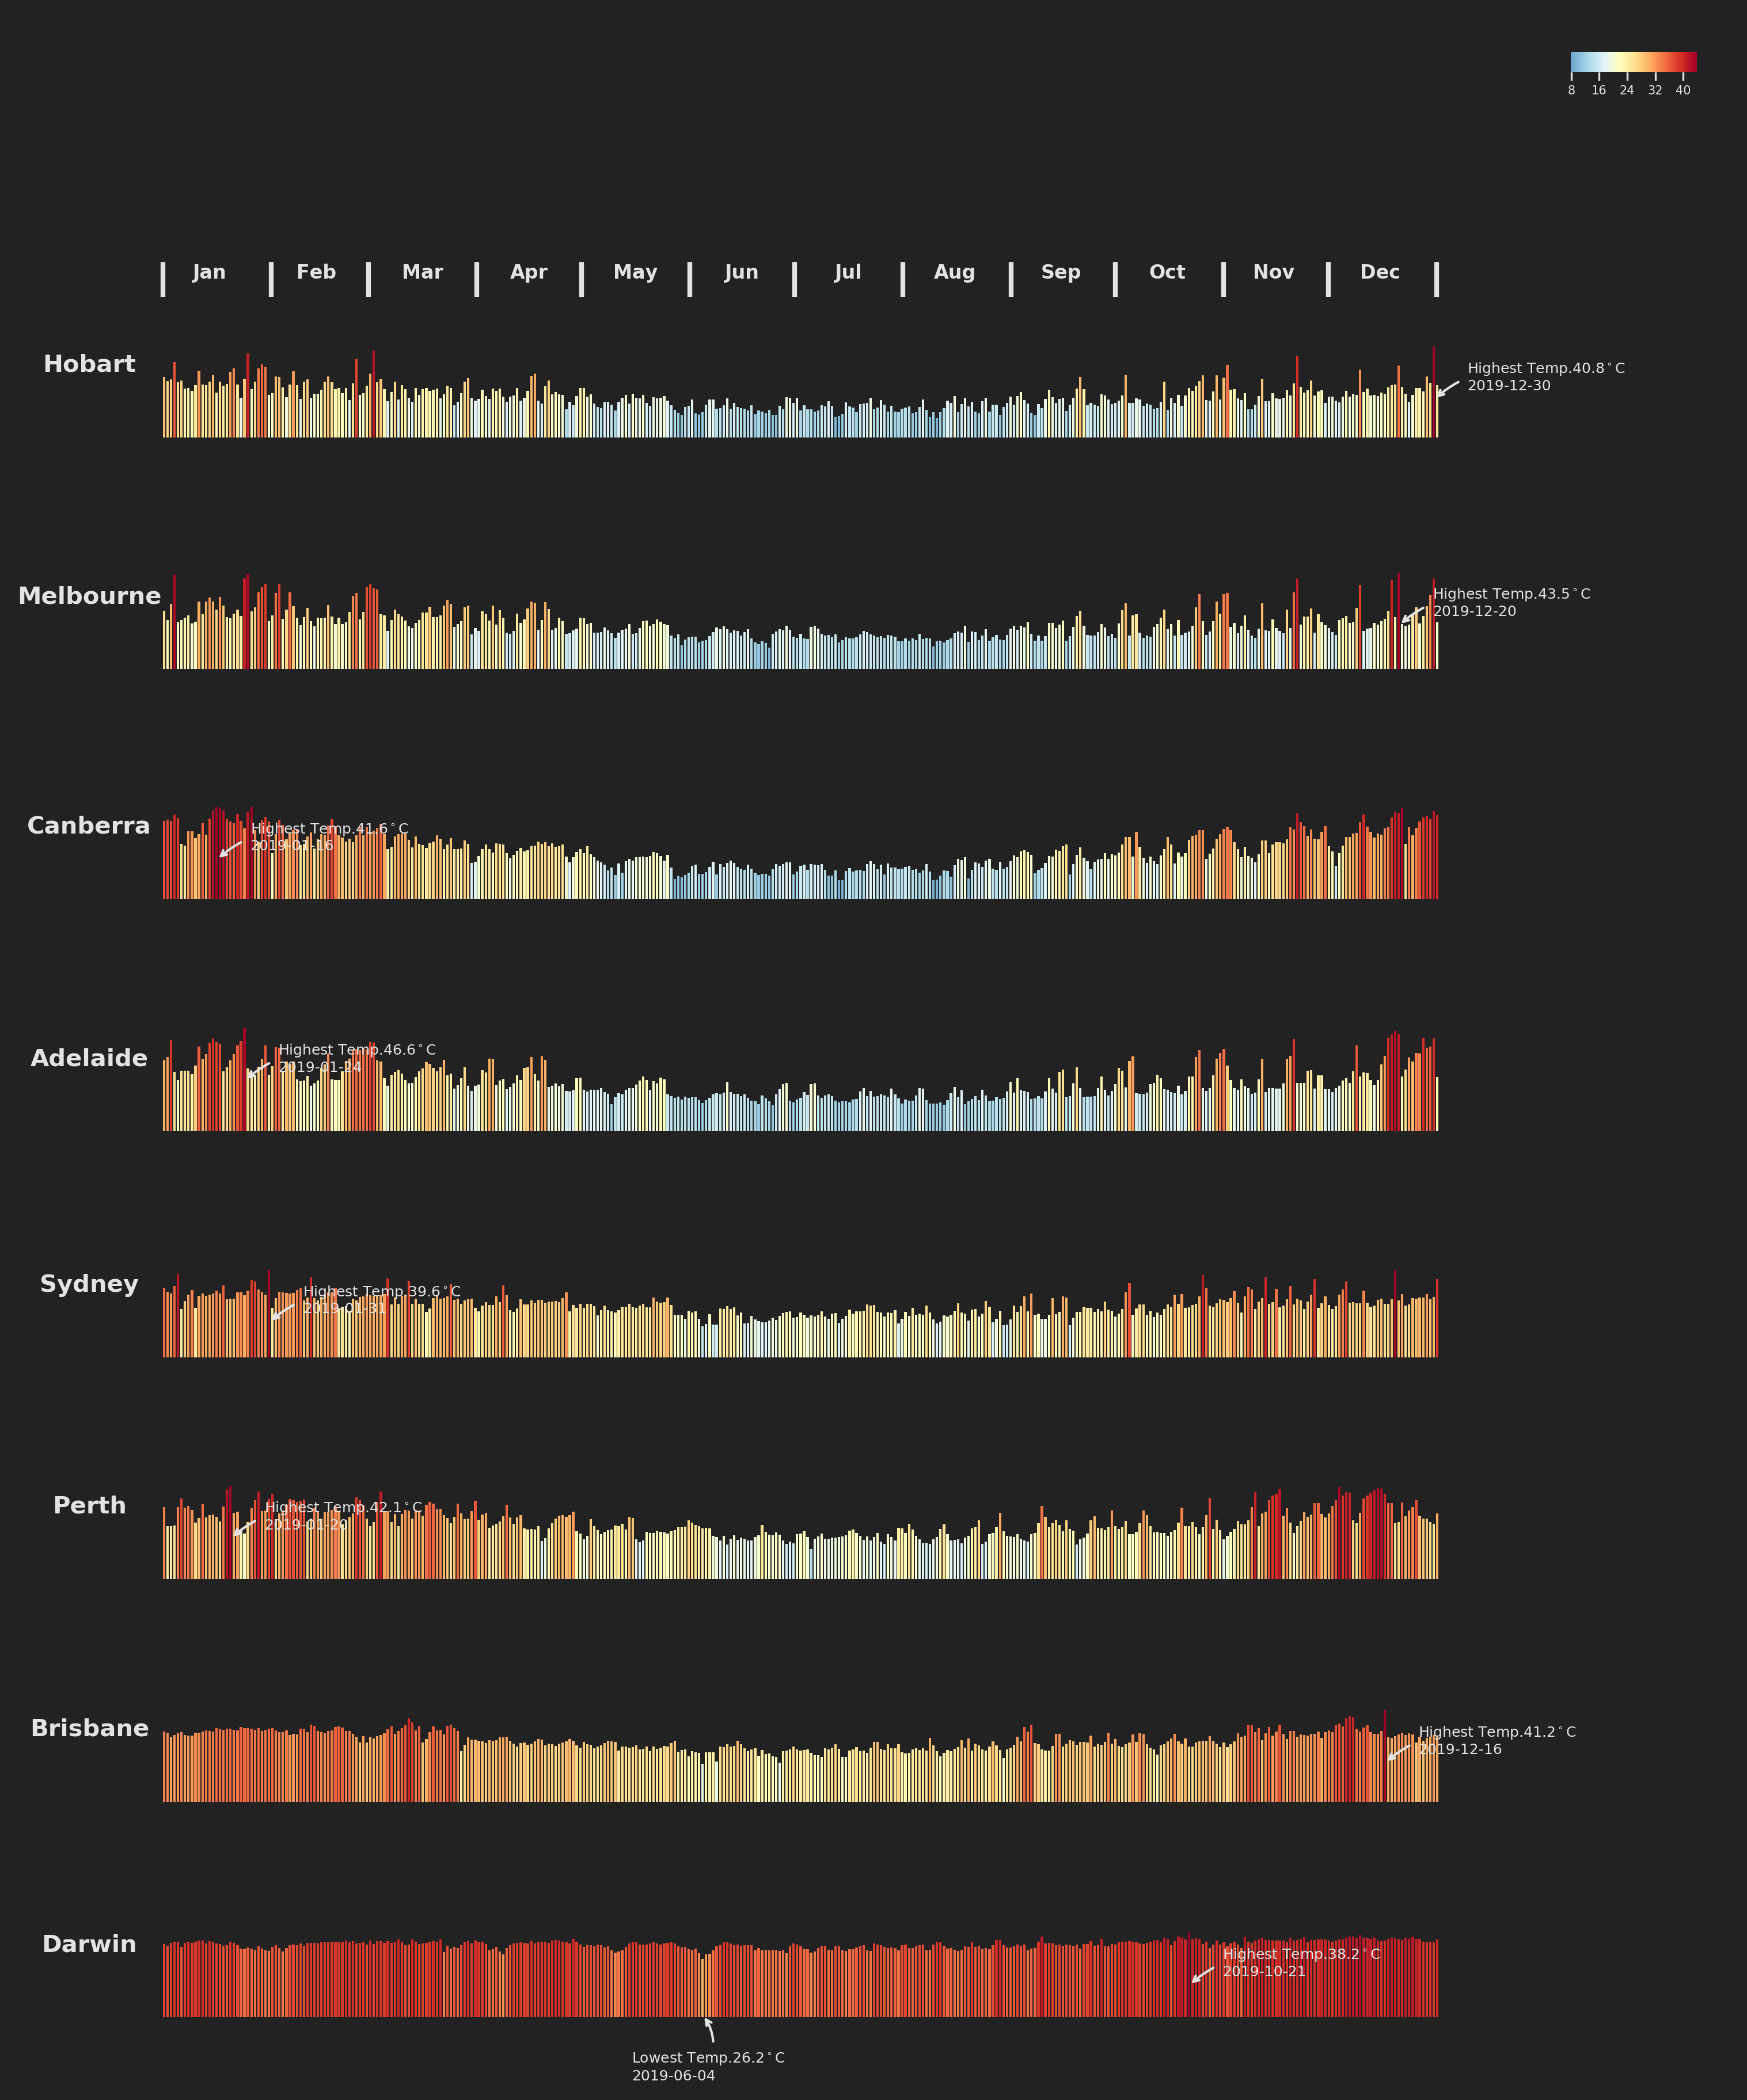

In [20]:
# Set canvas background color the same as axes
plt.rc('figure', facecolor='#222222')

# set constrianed_layout as True to avoid axes overlap
fig = plt.figure(figsize=(10,12), dpi=300, constrained_layout=True)
# Use GridSpec for customising laypout
gs = fig.add_gridspec(nrows=10, ncols=10)

# Set up a empty axes that occupied 2 rows for text
axText = fig.add_subplot(gs[0:2, 0:9])
# Turn off all grid, ticks & spines
axText.grid(False)
axText.get_yaxis().set_visible(False)

# Use Sydney data for building a empty axes
axText.bar(df.loc[df['City'] == 'sydney'].Date, df.loc[df['City'] == 'sydney'].max_tmp_day*0, label='_1',
           width=1.5, align="edge", zorder=1)

# Adjustment for x-axis tick and tickLabel
axText.tick_params(axis="x", direction="out", which='major', width=2, length=15)
axText.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Show major tick every month
axText.xaxis.set_major_formatter(mdates.DateFormatter("")) # Don't Show tick label
for i, mon in enumerate(calendar.month_abbr[1:13]):
    axText.text(0.079*(i*0.96+1), -0.05, mon,
                verticalalignment='center', horizontalalignment='center',
                fontsize=8, color='#e3e3e3', fontweight='bold',
                transform=axText.transAxes)

# Add text in the Axes coordinates
#axText.text(0.5, 0.8, "Temperature Patterns", 
#            verticalalignment='center', horizontalalignment='center',
#            fontsize=30, color='#e3e3e3', fontname='Baskerville', fontweight='bold',
#            transform=axText.transAxes)

# Add a color bar 
axInlet = fig.add_axes([0.9, 0.97, 0.08, 0.01], frameon=False)
# construct dummy value for color bar, length of x and y should be the same
xLegend = np.linspace(0, 179, 1800)
yLegend = np.linspace(min(df.max_tmp_day), max(df.max_tmp_day), 1800)
# Turn off all grid, ticks & spines
axInlet.grid(False)
axInlet.get_yaxis().set_visible(False)

colorsInlet = cm.RdYlBu_r(yLegend / max(yLegend))
axInlet.bar(xLegend, yLegend**0, label='_1', color=colorsInlet, align="center", zorder=0)

axInlet.tick_params(axis="x", direction="out", pad=2)
axInlet.xaxis.set_major_locator(MultipleLocator(40))
axInlet.set_xticklabels([4, 8, 16, 24, 32, 40], fontdict = {'fontsize': 5}, zorder=2)


for i, city in enumerate(cityList):
    ax = fig.add_subplot(gs[i+2, 0:9], ylim=(-30, 30))
    
    df_tmp = df.loc[df['City'] == city]
    # color scheme
    colors = cm.RdYlBu_r(df_tmp.max_tmp_day / max(df_tmp.max_tmp_day))
    ax.bar(df_tmp.Date, df_tmp.max_tmp_day - mean_temp, label='_1', color=colors,
           width=0.7, align="edge")
    
    # annotation for highest temp.
    highDate = df_tmp.loc[df_tmp['max_tmp_day'] == max(df_tmp.max_tmp_day)].Date
    highTemp = max(df_tmp.max_tmp_day) - mean_temp
    ax.annotate("Highest Temp.{}$^\circ$C\n{}".format(max(df_tmp.max_tmp_day), str(highDate)[-36:-26]),
                xy=(highDate, highTemp), xycoords='data',
                xytext=(highDate+timedelta(days=10), highTemp+5), textcoords='data',
                size=6,
                color='#e3e3e3',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3, rad=.3",
                                color='#e3e3e3')
               )
    # annotation for lowest temp.
    lowDate = df_tmp.loc[df_tmp['max_tmp_day'] == min(df_tmp.max_tmp_day)].Date
    lowTemp = min(df_tmp.max_tmp_day) - mean_temp
    ax.annotate("Lowest Temp.{}$^\circ$C\n{}".format(min(df_tmp.max_tmp_day), str(lowDate)[-36:-26]),
                xy=(lowDate, lowTemp), xycoords='data',
                xytext=(lowDate-timedelta(days=20), lowTemp-30), textcoords='data',
                size=6,
                color='#e3e3e3',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3, rad=.3",
                                color='#e3e3e3')
               )
    
    # customise axes
    ax.spines['bottom'].set_color(None)  
    ax.spines['right'].set_color(None)  
    ax.spines['left'].set_color(None)  
    ax.spines['top'].set_color(None) 
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel(city.title(), rotation=0, color='#e3e3e3', fontsize=10, fontweight='bold')
    
plt.show()

In [19]:
fig.savefig('example9.png', facecolor='#222222')

### Test Code Section

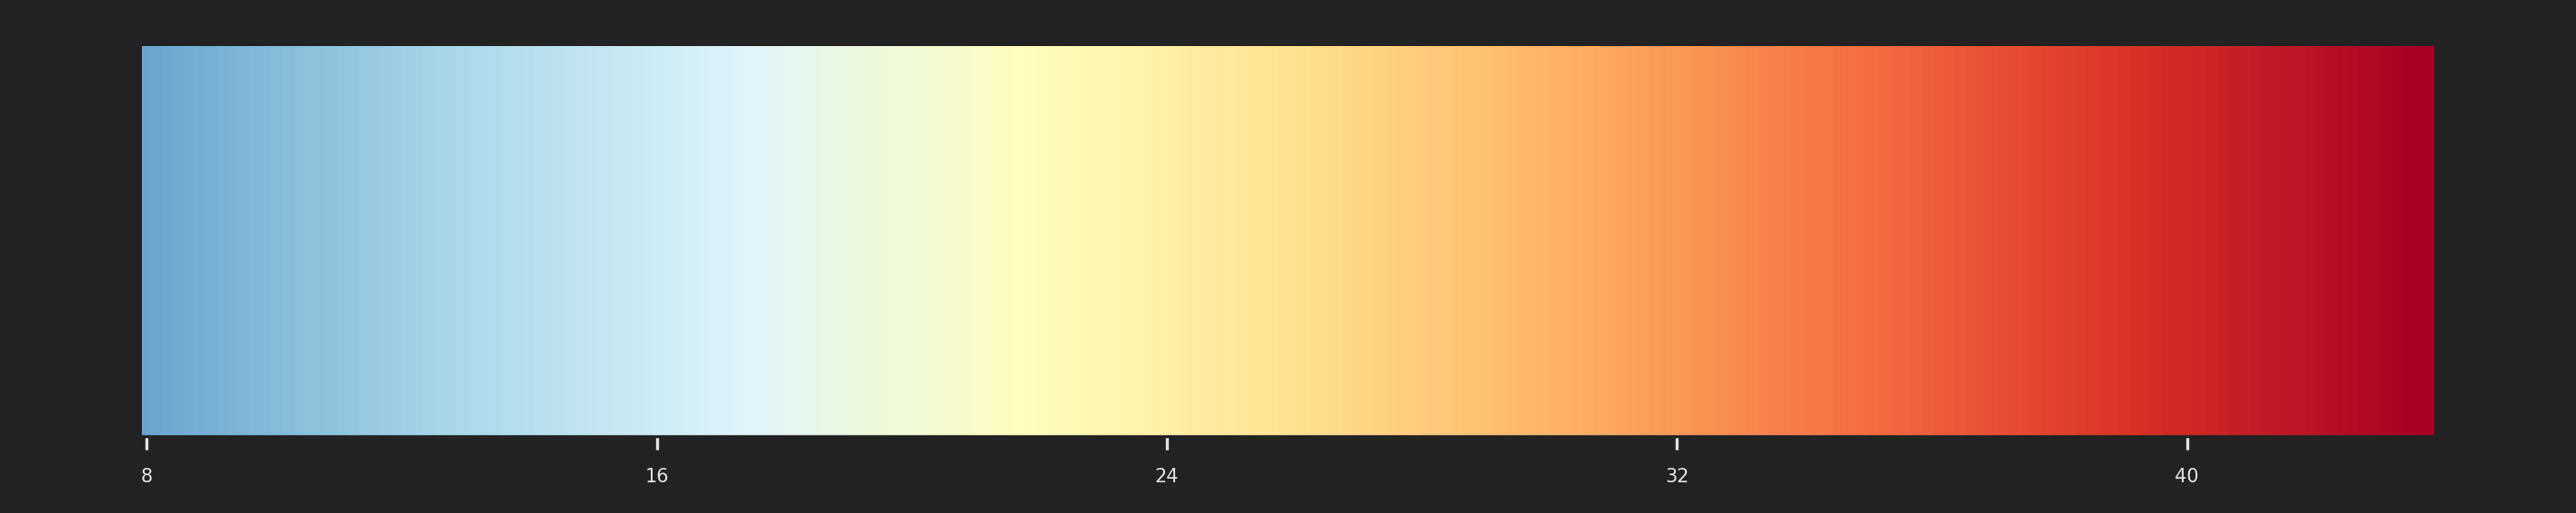

In [388]:
fig, ax = plt.subplots(dpi=300, figsize=(12,2))

# set x value as integer, otherwise there will be space between some bars as the line space is not evenly divided
xLegend = np.linspace(0, 179, 1800)
yLegend = np.linspace(min(df.max_tmp_day), max(df.max_tmp_day), 1800)
# Turn off all grid, ticks & spines
ax.grid(False)
ax.get_yaxis().set_visible(False)

colors = cm.RdYlBu_r(yLegend / max(yLegend))
ax.bar(xLegend, yLegend**0, label='_1', color=colors, align="center", zorder=0)

ax.tick_params(axis="x", direction="out", pad=5)
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.set_xticklabels([4, 8, 16, 24, 32, 40], fontdict = {'fontsize': 5}, zorder=2)


plt.show()

In [113]:
import calendar

calendar.month_abbr[1:13]

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [124]:
for i, mon in enumerate(calendar.month_abbr[1:13]):
    print(i, mon)

0 Jan
1 Feb
2 Mar
3 Apr
4 May
5 Jun
6 Jul
7 Aug
8 Sep
9 Oct
10 Nov
11 Dec
